# Importing useful libraries and starting setup

In [6]:
#TBC which one are really used or not

#libraries importing

#pd for read doc & dataframe
import pandas as pd
import spacy
#os for files loading
import os
#import re for preprocessing. Currently not used
#import re
#import wordcloud to nicely visualise most recurrent words
from wordcloud import WordCloud
#https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb
# importing CountVectorizer to make a bag of words model, not used currently
#from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
#importing distance metrics to generate a cosine similarity matrix
# importing metrics computing polynomial_kernel with degree=1 and coef0=0
from sklearn.metrics.pairwise import linear_kernel
# importing metrics computing L2-normalized dot product of vectors
from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.metrics.pairwise import cosine_similarity
# tf-idf functionality in sklearn.feature_extraction.text can produce normalized vectors,
# in which case cosine_similarity is equivalent to linear_kernel, only slower.
# source: https://scikit-learn.org/stable/modules/metrics.html

from nltk.tokenize import word_tokenize

#importing methods for lemmatization TBC by Emre
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

#NER methods
import nltk
#not used
#from nltk.tokenize import sent_tokenize
#from nltk.tag import pos_tag
#from nltk import ne_chunk_sents

#importint Counter to get words number from list
from collections import Counter

from typing import List

## importing gensim methods for tf-idf
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel

In [7]:
#models importing
#load md for modelling purpose
nlp = spacy.load('en_core_web_md')
#load only sm to save memory
#nlp = spacy.load('en_core_web_sm')

#for NEr
nltk.download('maxent_ne_chunker')
nltk.download('words')
stopwords_en = spacy.lang.en.stop_words.STOP_WORDS
# dealing with ValueError: [E088] Text of length 7539328 exceeds maximum of 1000000.
# The parser and NER models require roughly 1GB of temporary memory per 100,000 characters in the input.
# This means long texts may cause memory allocation errors. If you're not using the parser or NER,
# it's probably safe to increase the `nlp.max_length` limit. The limit is in number of characters,
# so you can check whether your inputs are too long by checking `len(text)`.
nlp.max_length = 8000000 #7539328

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Fra\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Fra\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [8]:
try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive/')
    START_PATH = '/content/drive/MyDrive'
    NEWS_PATH = os.path.join(START_PATH + r'/Becode/NLP/news_data.json')
else:
    # LOADING FILES NB
    START_PATH = os.path.dirname(os.getcwd())
    NEWS_PATH = os.path.join(START_PATH + r'\assets\news_data.json')

ENTITIES_PATH = os.path.join(START_PATH + r'\data\custom_entities.csv')
news: pd.DataFrame = pd.read_json(NEWS_PATH)
news: pd.DataFrame = pd.json_normalize(news['data'])

#usecases not used
#CASE_PATH = os.path.join(START_PATH + r'\assets\case_data.json')
#USECASES = os.path.join(START_PATH + r'\data\springboard_ai_usecases.csv')
#case: pd.DataFrame = pd.read_json(CASE_PATH)
#case: pd.DataFrame = pd.json_normalize(case['data'])
#usecases: pd.DataFrame = pd.read_csv(USECASES, delimiter=';', encoding='cp1252')
#usecols=['Usecase Description', 'Type', 'Industry', 'Impact', 'Data Richness'],

# Preprocessing files to help the model

In [9]:
#taking small sample of 100 just for testing purpose
#summary is not considered being already part of text
publications = news.loc[:, ['title', 'tags', 'text',]]#.sample(100)
#merging into doc to get as many information as possible.
publications['doc'] =  publications.apply(lambda x: ".".join([x['title'], x['tags'], x['text']]), axis=1)

#case['doc'] =  case.apply(lambda x: ".".join([x['name'], x['metrics'], x['description'], ]), axis=1)

## Creating set of NER

In [10]:
#creating a single ner set
nes = set()
#function to extract NER from text
def get_named_entities(text) -> set:
    doc = nlp(text)
    named_entities = set([ent.text for ent in doc.ents])
    return named_entities
[[nes.add(n) for n in get_named_entities(text)] for text in publications.text]
len(nes)
#manually adding some words later discovered
nes.add('microsoft')

## Tokenization, lowering case, retaining alphabetic words & remove NERs

In [11]:
def tokenization(texts_doc: pd.Series) -> List[List[str]]:
    # Tokenize the article: tokens
    tokens =[word_tokenize(article) for article in texts_doc]
    # Convert the tokens into lowercase: lower_tokens
    lower_tokens = [[t.lower() for t in token] for token in tokens]
    # Retain alphabetic words: alpha_only
    alphas = [[t for t in lower_token if t.isalpha()] for lower_token in lower_tokens]
    # Remove all stop words: no_stops
    no_stops = [[t for t in alpha if t not in stopwords_en] for alpha in alphas]
    # Remove all NER
    no_nes = [[t for t in no_stop if t not in nes] for no_stop in no_stops]
    return no_nes
publications_tokens = tokenization(texts_doc = publications.doc)

#cases_tokens = tokenization(texts_doc = case.doc)

## Lemmatization
Lemmatization for topic modelling and helping the processing

In [12]:
def lemmatization(docs_tokens: List[List[str]]) -> List[List[str]]:
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    # Instantiate the WordNetLemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    # Lemmatize all tokens into a new list: lemmatized
    docs_lemmatized = [[wordnet_lemmatizer.lemmatize(t, get_wordnet_pos(t)) for t in doc_tokens]
                               for doc_tokens in docs_tokens]
    return docs_lemmatized
publications_lemmatized = lemmatization(publications_tokens)

#cases_lemmatized = lemmatization(cases_tokens)

##  Overview of most common words
Identifying most common generic ai words to be removed helping the model to detect specific usecases in AI articles.
https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer

### Identification for publications

In [13]:
#https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer
def get_words_frequency(docs_lemmatized: List[List[str]], freq_min = None, freq_max = None) -> List[List[str]]:
    frequency_absolute =Counter([ item for elem in docs_lemmatized for item in elem])
    #DEV NOTE wordcloud to be replaced with better methods
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(frequency_absolute)
    #absolute frequency not needed
    #word_freq={k: v for k, v in sorted(word_cloud_dict.items(),reverse=True, key=lambda item: item[1])}
    #getting relative frequency in order
    rel_freq=wordcloud.words_
    rel_freq_filtered = rel_freq.copy()
    if freq_min is not None and freq_min > 0 and freq_min < 1:
        rel_freq_filtered = {k: v for k, v in rel_freq_filtered.items() if v > freq_min}
    if freq_max is not None and freq_max > 0 and freq_max < 1:
        rel_freq_filtered = {k: v for k, v in rel_freq_filtered.items() if v < freq_max}
    return rel_freq, rel_freq_filtered, wordcloud

[('s', 1.0), ('ai', 0.9231985766531581), ('say', 0.6917070277750321)]
[('complex', 0.054957003064149454), ('mean', 0.05475931600276762), ('institute', 0.05475931600276762)]


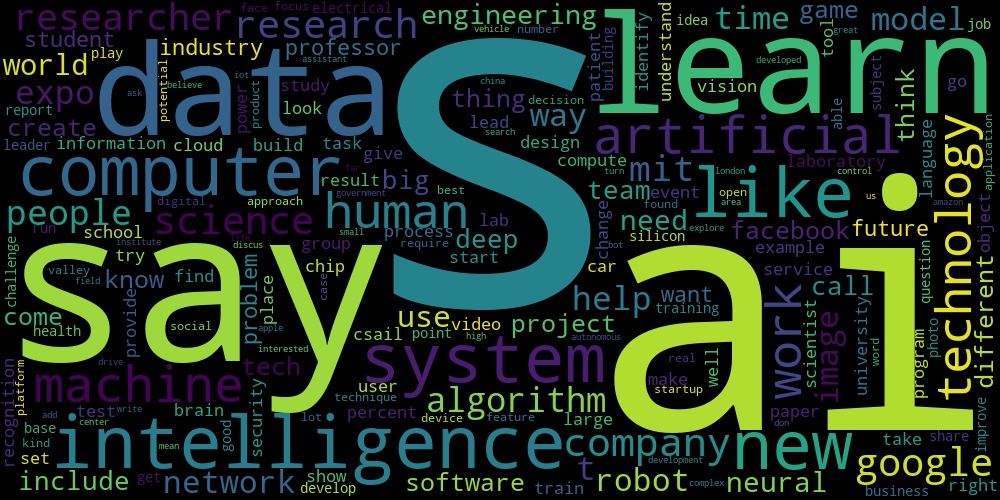

In [14]:
publication_freq, publication_freq_filtered, wordcloud = get_words_frequency(publications_lemmatized, freq_min=0.05, freq_max=0.95)
print(list(publication_freq.items())[:3])
print(list(publication_freq.items())[-3:])
wordcloud.to_image()

[('ai', 0.9231985766531581), ('say', 0.6917070277750321), ('learn', 0.5750716615597509)]
[('complex', 0.054957003064149454), ('mean', 0.05475931600276762), ('institute', 0.05475931600276762)]


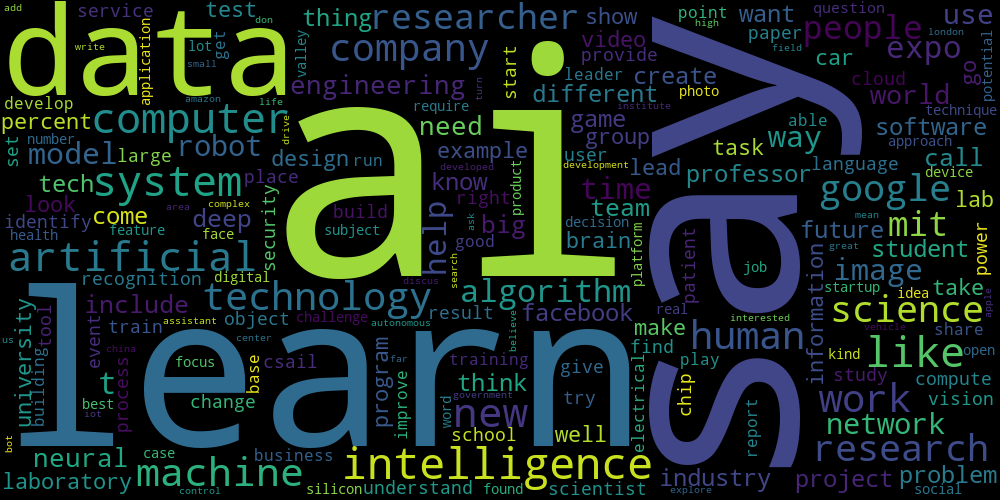

In [15]:
print(list(publication_freq_filtered.items())[:3])
print(list(publication_freq_filtered.items())[-3:])
wordcloud_filtered = WordCloud(width = 1000, height = 500).generate_from_frequencies(publication_freq_filtered)
wordcloud_filtered.to_image()

### Identification for cases

cases procedures excluded

cases_freq, cases_freq_filtered, wordcloud = get_words_frequency(cases_lemmatized, freq_min=0.25, freq_max=0.75)
print(list(cases_freq.items())[:3])
print(list(cases_freq.items())[-3:])
wordcloud.to_image()


print(list(cases_freq_filtered.items())[:3])
print(list(cases_freq_filtered.items())[-3:])
wordcloud_filtered = WordCloud(width = 1000, height = 500).generate_from_frequencies(cases_freq_filtered)
wordcloud_filtered.to_image()

### Removal of most and least frequent words

In [33]:
publications_filtered = [[t for t in pub_lem if t in publication_freq_filtered.keys()] for pub_lem in publications_lemmatized]
print(f'Publications words: {len(publications_filtered)}')

Publications words: 1626


cases_filtered = [[t for t in case_lem if t in cases_freq_filtered.values()] for case_lem in cases_lemmatized]
print(f'Cases words: {len(cases_filtered)}')

# Predict industry type with tf-idf words by using similarity method

## Preliminary definition of keywords per industry

In [17]:
industry_words = {
    'automative': ['automotive', 'taxi', 'wheel', 'fuel', 'car','drive','auto','selfdrive','vehicle','road','automobile'],
    'Manufacturing': ['cleantech', 'deindustrialization', 'prefabrication', 'manufacturing', 'vitrification', 'fabrication' 'R&D','quality','produce','goods','factory','equipment'],
    'Consumer Products' : ['product', 'price', 'goods', 'commerce', 'economic', 'customer','marketing','demand','inventory','supply'],
    'Finance' : ['bank', 'money', 'capitalization', 'interest', 'fund', 'finance', 'asset','risk','loan','credit','fraud'],
    'Agriculture' :['soil', 'grain', 'agriculture', 'field','farm','soil','weather','crop','grow','animal', 'food' , 'land'],
    'Energy' : ['renewable', 'sustainable', 'green', 'electricity', 'energy', 'power','mines','solar','light','metal','electric','carbon', 'electonic','wind','speed'],
    'Health Care' : ['Health', 'Care', 'emergency','doctor','wellness','patient','hospital', 'clinic','treatment','disease', 'medical','cancer'],
    'Pharmaceuticals' : ['dose', 'pillbox', 'tonic', 'tablet', 'placebo', 'medicate', 'hospital', 'Pharmaceutical', 'drug','diagnose', 'test','trial','medicine', 'vaccine'],
    'Public and Social sector' : ['social', 'law','crime','terrorism','policing','govern', 'public', 'infrastructure', 'education', 'tax', 'urban', 'life', 'job','enforcement', 'surveillance'],
    'Media' :['mainstream', 'publishing', 'medium', 'social','media','video','content','news','release','film', 'press', 'viral', 'game'],
    'Telecom' : ['location', 'station', 'host', 'telecom', 'mobile', 'voice','call','subscription','network','phone', 'broadcast', 'internet','communication' ,'modulation'],
    'Transport & Logistics' : ['transport' , 'logistic', 'mail','parcel','travel','route','planes','truck', 'shipping', 'mobility', 'movement']
}
for keys, value in industry_words.items():
    industry_words[keys] = " ".join(value)

## Create a Dictionary from the articles: dictionary

In [34]:
dictionary = Dictionary(publications_filtered)

## Create a MmCorpus: corpus

In [35]:
corpus = [dictionary.doc2bow(publication) for publication in publications_filtered]

# Create a new TfidfModel using the corpus: tfidf

In [36]:
tfidf = TfidfModel(corpus)
tfidf_weights = [sorted(tfidf[doc], key=lambda w: w[1], reverse=True) for doc in corpus]

## Create nlp object for each industry category and key_list

In [37]:
key_list = list(industry_words.keys())
doc_industry_list = []
for key, value in industry_words.items():
        doc_industry_list.append(nlp(industry_words[key]))

## Predict industry type with similarity method along two nlp object for all texts in industry_type_list
Select the most important first 20 words for each text a and convert list into string

In [38]:
publications_strings = [[dictionary.get(term_id) for term_id, weight in tfidf_weight[:20]] for tfidf_weight in tfidf_weights]
publications_strings = [" ".join(publications_string) for publications_string in publications_strings]

industry_type_list = []
for publication in publications_strings:
    # Create nlp object for an cleaned article
    doc_publication = nlp(publication)
    similarities = []
    for doc_industry in doc_industry_list:
        similarities.append(doc_publication.similarity(doc_industry))
    max_value = max(similarities)
    max_position = similarities.index(max_value)
    industry_type = key_list[max_position]
    industry_type_list.append(industry_type)

In [26]:
len(industry_type_list)

1626

In [39]:
[i for i in industry_type_list if i != 'automative'][:5]

['Public and Social sector',
 'Media',
 'Media',
 'Public and Social sector',
 'Consumer Products']